# Анализ эффективности программы лояльности магазина



### Задача:   
Оценить эффект от использования клиентами  магазина программы лояльности по данным о покупках за 3 месяца


### Содержание

- [1. Предобработка данных](#step1) 

- [2. Исследовательский анализ данных](#step2):

    - [2.1. Распределение заказов и покупателей по магазинам ](#step3) 

    - [2.2. Стоимость и размер заказов](#step4) 
 
    - [2.3.  Распределение покупателей и покупок по времени ](#step5) 
   
    - [2.4.  Количество заказов и средний чек для каждого покупателя ](#step6) 
    
- [3.  Проверка влияния программы лояльности клиентов на средний чек и объем покупок](#step7) 
    - [3.1. Средняя выручка с заказа](#step8)
    - [3.2.  Средний размер корзины и средний чек](#step9)     
    - [3.3. Процент возвратов товара](#step10) 

- [4.Выводы](#step11)


In [1]:
#импортирование библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats as st
import datetime
import math as mth

import warnings
warnings.filterwarnings("ignore")

#pd опции 
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
sns.set()

In [2]:
 #используемые функции

def firstlook_df(df):
    '''
    Функция для датафрейма df выводит:
    - первые и последние 5 строчек таблицы, 
    -общую информацию о таблице,
    -количество дубликатов и пропусков   
    '''
    separator_line =25*('--')
    print(separator_line)
    print('Первые 5 строк таблицы:')
    print(separator_line)
    display(df.head())
    print(separator_line)
    print('Последние 5 строк таблицы:')
    print(separator_line)
    display(df.tail())
    
    print(separator_line)
    print('Общая информация о данных:')
    print(separator_line)
    display(df.info()) 
    
    print(separator_line)
    print('Проверка на наличие дубликатов и пропусков:')
    print(separator_line) 
    print('Количество строк-дубликатов = ', df.duplicated().sum())
    for column in df.columns:
        n_nulls = df[column].isnull().sum()
        print(f'Количество пропусков в столбце {column} = {n_nulls}')
    print(separator_line)  
 

    
    # проверка статистической значимости   
def check_stat_significance(successes_0, total_0, successes_1, total_1, alpha = 0.05):
    
    '''
     функция проверяет гипотезу о равенстве долей  между successes и total между двумя совокупностями (0 и 1)
     при заданом уровне значимости alpha
    '''
    
    # критический уровень статистической значимости
    # пропорция успехов в первой группе:
    p1 = successes_0/total_0

    # пропорция успехов во второй группе:
    p2 = successes_1/total_1

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes_0 + successes_1) / (total_0 + total_1)

    # разница пропорций в датасетах
    difference = p1 - p2
    print(p_combined*(1-p_combined) * (1/total_0 + 1/total_1) )

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference/mth.sqrt( p_combined*(1-p_combined) * (1/total_0 + 1/total_1) )


    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0,1)


    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    separator_line =35*('--')
    print(separator_line)
    print('Разница в долях = {0:0.2%}'.format(difference))
    print('p-значение = ', p_value)

    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        
    print(separator_line)

 # построение графиков   

def plot_daily_stats(daily_data, column, title, ylabel):
    '''
    функция сторит график параметра column по дням - общее и с разбивкой по группам лояльности
    title = название графика
    ylabel = название оси у
    '''

    fig, ax = plt.subplots(2,1, figsize = (12,8))
    ax = ax.flatten()
    for i in range(0,2):
        if i == 0:
            data = daily_data.groupby('day')[column].sum().reset_index()
            if column == 'avg_check':
                data = daily_data.groupby('day')[column].mean().reset_index()
                
            print(f'Средние значения столбца {column}:')
            print(data[column].mean())
            
            sns.lineplot(x = 'day', 
                        y = column,
                        data = data,
                        marker = 'o',
                        ax = ax[i])
        else:
            sns.lineplot(x = 'day', 
                y = column,
                hue = 'loyalty_label',
                style = 'loyalty_label',
                data = daily_data,
                markers = ['o','>'])

            ax[i].legend()

        ax[i].set(title = title,
                 xlabel = 'Дата',
                 ylabel = ylabel)

    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()
        
    
    print('Средние значения по группам:')
    print(daily_data.groupby('loyalty_label')[column].mean())


def plot_period_stats(period_data, period, column, title, ylabel):
    '''
    функция сторит график параметра column по  периодам времени period - общее и с разбивкой по группам лояльности
    title = название графика
    ylabel = название оси у
    '''
    fig, ax = plt.subplots(2,1, figsize = (12,8))
    ax = ax.flatten()
    for i in range(0,2):
        if i == 0:
            data = period_data.groupby(period)[column]\
                        .sum()\
                        .reset_index()
            if column == 'avg_check':
                data = period_data.groupby(period)[column]\
                        .mean()\
                        .reset_index()
                
            data.plot.bar(x = period,
                                  y = column,
                                  ax = ax[i],
                                 label = 'все покупатели')
            
            print(f'Средние значения столбца {column}:')
            print(data[column].mean())
    

        else:
            period_pivot  =  period_data.pivot_table(index = period, 
                                                    columns = 'loyalty_label', 
                                                    values = column, 
                                                    aggfunc  = 'mean')

            period_pivot.index = period_pivot.index.to_period("d")
            period_pivot.plot.bar(ax = ax[1], grid = True)
            ax[i].legend()

        ax[i].set(title = title,
                 xlabel = 'Дата',
                 ylabel = ylabel)
        
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()
    
    print('Средние значения по группам:')
    print(period_data.groupby('loyalty_label')[column].mean())

    
    
def  group_period_data(data, period = 'day'):
    '''
      группирует данные по периоду времени (дефолт = день)
      и считает  количество покупок, покупателей, выручку и средний чек
      
    '''
    loyalty_label = {0:'обычные покупатели', 1:'участники программы лояльности'}
    period_data = ( data.groupby([period,'loyalty_program'])
                                .agg(
                                purchase_count = ('purchase_id','nunique'),
                                revenue = ('total_price','sum'),
                                customer_count = ('customer_id','nunique')
                                ).reset_index()
                        
                           .assign(
                                avg_check = lambda x: x['revenue']/x['purchase_count'],
                                loyalty_label = lambda x: x['loyalty_program'].map(loyalty_label) # для графиков

                                )
                )

    
    return period_data

def plot_customer_hist(customer_data, column, title, xlabel, check_cutoff = 4000, binsize = 100):
    '''
    функция сторит гистограму параметра column 
    title = название графика
    ylabel = название оси у
    '''
    print(f'Средние значения для {column}')
    display(customer_data[column].mean())
    display(customer_data.groupby('loyalty_label')[column].mean())  
    fig, ax = plt.subplots(1,2, figsize = (16,6))   
    for i in range(0,2):

        if i == 0:
            sns.distplot(customer_data[column], 
                 bins = range(0,check_cutoff,binsize),
                 kde = False,
                 ax = ax[i])

        else:
            for key, value in  loyalty_label.items():
                sns.distplot(customer_data.query('loyalty_program == @key')[column], 
                             kde = False,
                             bins = range(0,check_cutoff,binsize),
                             label = value,
                             ax = ax[i])
            ax[i].legend()

        ax[i].set(title = title,
                xlabel = xlabel,
                ylabel = ' Частота')

## 1. Предобработка данных  <a id="step1">

 Прочитаем данные о покупках:

In [3]:
retail_df = pd.read_csv('retail_dataset.csv')
firstlook_df(retail_df)

--------------------------------------------------
Первые 5 строк таблицы:
--------------------------------------------------


,purchaseid,item_ID,Quantity,purchasedate,CustomerID,ShopID,loyalty_program
0,538280,21873,11,2016-12-10 12:50:00,18427.00,Shop 0,0.00
1,538862,22195,0,2016-12-14 14:11:00,22389.00,Shop 0,1.00
2,538855,21239,7,2016-12-14 13:50:00,22182.00,Shop 0,1.00
3,543543,22271,0,2017-02-09 15:33:00,23522.00,Shop 0,1.00
4,543812,79321,0,2017-02-13 14:40:00,23151.00,Shop 0,1.00


--------------------------------------------------
Последние 5 строк таблицы:
--------------------------------------------------


,purchaseid,item_ID,Quantity,purchasedate,CustomerID,ShopID,loyalty_program
105330,538566,21826,1,2016-12-13 11:21:00,nan,Shop 0,0.00
105331,540247,21742,0,2017-01-05 15:56:00,21143.00,Shop 0,0.00
105332,538068,85048,1,2016-12-09 14:05:00,23657.00,Shop 0,1.00
105333,538207,22818,11,2016-12-10 11:33:00,18427.00,Shop 0,0.00
105334,543977,22384,9,2017-02-14 15:35:00,21294.00,Shop 0,0.00


--------------------------------------------------
Общая информация о данных:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
purchaseid         105335 non-null object
item_ID            105335 non-null object
Quantity           105335 non-null int64
purchasedate       105335 non-null object
CustomerID         69125 non-null float64
ShopID             105335 non-null object
loyalty_program    105335 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ MB


None

--------------------------------------------------
Проверка на наличие дубликатов и пропусков:
--------------------------------------------------
Количество строк-дубликатов =  1033
Количество пропусков в столбце purchaseid = 0
Количество пропусков в столбце item_ID = 0
Количество пропусков в столбце Quantity = 0
Количество пропусков в столбце purchasedate = 0
Количество пропусков в столбце CustomerID = 36210
Количество пропусков в столбце ShopID = 0
Количество пропусков в столбце loyalty_program = 0
--------------------------------------------------


- В данных 105335 строки и 7 колонок
- для удобства колонки следует переименовать и привести к нижнему регистру
- purchace_date - нужно перевести во временной формат
- quantity минимальное значение -74216.00 и максимальное такое же по одному и тому же покупателю и продукту, похоже на ошибку ввода и потом возврат - уберем эти значения
- в customerID есть 36 210 строк-пропусков, это треть данных, удалим их, так как нам нужно оценить поведение покупателей, а без customer_id  невозможно привязать заказы к покупателю
- в данных 1033 строки-дубликата - удалим их

In [4]:
# удалим дубликаты, переименуем столбцы и приведем к нужным типам
retail_df = retail_df.dropna()\
                    .drop_duplicates()\
                    .rename(columns = {'purchaseid':'purchase_id',
                                       'item_ID':'item_id',
                                       'Quantity':'quantity',
                                       'purchasedate':'purchase_date',
                                       'CustomerID':'customer_id',
                                      'ShopID':'shop_id'
                                       })\
                    .assign(
                            purchase_date = lambda x: pd.to_datetime(x['purchase_date']),
                            year = lambda x: x['purchase_date'].astype('datetime64[Y]'),
                            month = lambda x: x['purchase_date'].astype('datetime64[M]'),
                            week = lambda x: x['purchase_date'].astype('datetime64[W]'),
                            day = lambda x: x['purchase_date'].astype('datetime64[D]'),
                            loyalty_program = lambda x: x['loyalty_program'].astype('int')
                        )

# убираем ошибочные значения в количестве товаров
retail_df = retail_df.drop(retail_df[retail_df["quantity"] ==  retail_df["quantity"].max()].index)\
                     .drop(retail_df[retail_df["quantity"] ==  retail_df["quantity"].min()].index)   

display(retail_df["quantity"].describe())
retail_returns = retail_df[retail_df["quantity"] < 0]  # сохраним возвраты
retail_df = retail_df.drop(retail_df[retail_df["quantity"] <= 0].index)  # убираем нулевые и отрицательное количество чеков

display(retail_df.head())
display(retail_df.info())


count   68152.00
mean       11.12
std        60.77
min     -9361.00
25%         1.00
50%         4.00
75%        11.00
max      3905.00
Name: quantity, dtype: float64

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,year,month,week,day
0,538280,21873,11,2016-12-10 12:50:00,18427.00,Shop 0,0,2016-01-01,2016-12-01,2016-12-08,2016-12-10
2,538855,21239,7,2016-12-14 13:50:00,22182.00,Shop 0,1,2016-01-01,2016-12-01,2016-12-08,2016-12-14
10,537795,82494L,5,2016-12-08 13:03:00,22892.00,Shop 0,1,2016-01-01,2016-12-01,2016-12-08,2016-12-08
12,543647,21987,3,2017-02-10 19:49:00,18520.00,Shop 0,0,2017-01-01,2017-02-01,2017-02-09,2017-02-10
13,538533,22294,9,2016-12-13 10:31:00,20475.00,Shop 0,0,2016-01-01,2016-12-01,2016-12-08,2016-12-13


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53883 entries, 0 to 105334
Data columns (total 11 columns):
purchase_id        53883 non-null object
item_id            53883 non-null object
quantity           53883 non-null int64
purchase_date      53883 non-null datetime64[ns]
customer_id        53883 non-null float64
shop_id            53883 non-null object
loyalty_program    53883 non-null int64
year               53883 non-null datetime64[ns]
month              53883 non-null datetime64[ns]
week               53883 non-null datetime64[ns]
day                53883 non-null datetime64[ns]
dtypes: datetime64[ns](5), float64(1), int64(2), object(3)
memory usage: 4.9+ MB


None

- переименовали колонки, изменили тип данных для даты покупки
- удалили дубликаты и строки с пропусками
- удалили строки с нулевым или отрицательным количеством покупок

В итоге в таблице осталось 53884 строки, чуть больше половины оригинальных данных.

Чтение таблицы с продуктами:

In [5]:
# чтение таблицы с продуктами

product_df = pd.read_csv('product_codes.csv')
firstlook_df(product_df)

--------------------------------------------------
Первые 5 строк таблицы:
--------------------------------------------------


,productID,price_per_one
0,85123A,2.55
1,71053,3.39
2,84406B,2.75
3,84029G,3.39
4,84029E,3.39


--------------------------------------------------
Последние 5 строк таблицы:
--------------------------------------------------


,productID,price_per_one
9964,84306,8.29
9965,90001A,4.15
9966,90118,2.46
9967,DOT,172.62
9968,20738,0.00


--------------------------------------------------
Общая информация о данных:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9969 entries, 0 to 9968
Data columns (total 2 columns):
productID        9969 non-null object
price_per_one    9969 non-null float64
dtypes: float64(1), object(1)
memory usage: 155.9+ KB


None

--------------------------------------------------
Проверка на наличие дубликатов и пропусков:
--------------------------------------------------
Количество строк-дубликатов =  0
Количество пропусков в столбце productID = 0
Количество пропусков в столбце price_per_one = 0
--------------------------------------------------


- В таблице продуктов 9969 строк-товаров без пропусков с нужным типом данных

Переименуем столбцы и найдем количество уникальных товаров, для товаров с несколькими ценами примем за цену медианное значение.

In [6]:
# таблица цен
product_df = product_df.rename(columns = {'productID':'item_id'} )

print('Количество уникальных товаров в чеках = ', retail_df['item_id'].nunique())
print('Количество уникальных товаров в ассортименте  = ', product_df['item_id'].nunique())

# сгруппируем продукты по  id товара и медиану цены для каждого товара
unique_products = product_df.groupby(['item_id'])['price_per_one'].median().reset_index()
display(unique_products.head())

Количество уникальных товаров в чеках =  2578
Количество уникальных товаров в ассортименте  =  3159


,item_id,price_per_one
0,10002,1.63
1,10080,0.85
2,10120,0.21
3,10123C,0.65
4,10124A,0.42


В ассортименте  3159 уникальных товаров, в чеках при этом встречается 2579.  Объединим таблицы с покупками с таблицей цен на товары и посчитаем общую стоимость покупки:

In [7]:
retail_df = retail_df.merge(unique_products, on = 'item_id')
retail_df['total_price'] = retail_df['quantity'] * retail_df['price_per_one']
display(retail_df.head())
#display(retail_df.info())

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,year,month,week,day,price_per_one,total_price
0,538280,21873,11,2016-12-10 12:50:00,18427.00,Shop 0,0,2016-01-01,2016-12-01,2016-12-08,2016-12-10,1.63,17.93
1,541566,21873,35,2017-01-19 11:50:00,23401.00,Shop 0,1,2017-01-01,2017-01-01,2017-01-19,2017-01-19,1.63,57.05
2,538843,21873,1,2016-12-14 13:18:00,21712.00,Shop 0,0,2016-01-01,2016-12-01,2016-12-08,2016-12-14,1.63,1.63
3,540838,21873,11,2017-01-11 15:13:00,19541.00,Shop 0,0,2017-01-01,2017-01-01,2017-01-05,2017-01-11,1.63,17.93
4,543592,21873,5,2017-02-10 11:57:00,22922.00,Shop 0,1,2017-01-01,2017-02-01,2017-02-09,2017-02-10,1.63,8.15


Получили таблицу с данными о покупках с ценами

## 2.  Исследовательский анализ данных     <a id="step2">

### 2.1. Распределение заказов и покупателей по магазинам     <a id="step3">
    
Посчитаем количество покупок, выручку и количество покупаетелей по магазинам:

Количество магазинов =  29


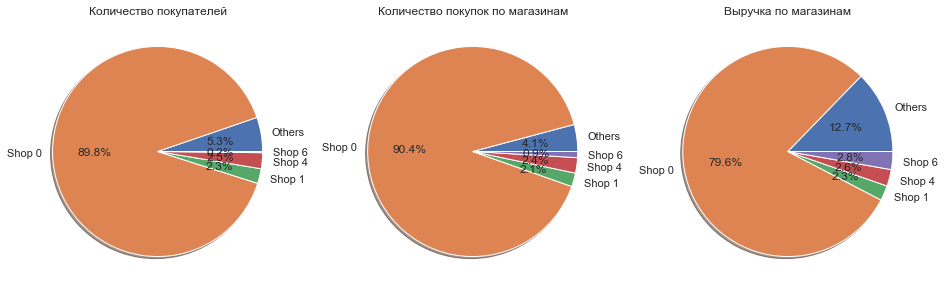

In [8]:
# посчитаем количество покупок, выручку и количество покупаетелей по магазинам

shop_data = (retail_df.groupby(['shop_id','loyalty_program'])
                                .agg(
                                purchase_count = ('purchase_id','nunique'),  
                                purchase_revenue = ('total_price','sum'),
                                customer_count = ('customer_id','nunique')
                                ).reset_index().sort_values(by = 'purchase_count', ascending = False)
            )


shop_data['label'] = shop_data['shop_id'].where(shop_data['purchase_count'] > 20, 'Others')

print('Количество магазинов = ', shop_data['shop_id'].nunique())

shop_for_pie = (shop_data.groupby('label').agg(purchase_count =('purchase_count','sum'),
                              purchase_revenue = ('purchase_revenue','sum'),
                              customer_count = ('customer_count','sum'))
                            .reset_index()
        )


fig, ax = plt.subplots(1,3, figsize = (16,10))

#соотношение покупаетелей по магазинам
ax[0].pie(shop_for_pie['customer_count'], 
        labels = shop_for_pie['label'],
        autopct='%1.1f%%',
        shadow=True)

ax[0].set(title = 'Количество покупателей')

ax[1].pie(shop_for_pie['purchase_count'], 
        labels = shop_for_pie['label'],
        autopct='%1.1f%%',
        shadow=True)

ax[1].set(title = 'Количество покупок по магазинам')
ax[2].pie(shop_for_pie['purchase_revenue'], 
        labels = shop_for_pie['label'],
        autopct='%1.1f%%',
        shadow=True)

ax[2].set(title = 'Выручка по магазинам')


plt.show()


In [9]:
display(shop_data.query('loyalty_program == 1'))


,shop_id,loyalty_program,purchase_count,purchase_revenue,customer_count,label
1,Shop 0,1,1114,579518.01,558,Shop 0
13,Shop 19,1,3,10025.71,1,Others
30,Shop 8,1,2,255.05,1,Others
21,Shop 28,1,1,1621.89,1,Others


- В таблице представлены данные из 29 магазинов, при этом 90% покупателей, 90.4% покупок и 79.6 % выручки приходится на магазин shop 0
- программой лояльности пользуются только покупателей магазина 0,  лишь в трех других(19, 8,28) встречаются по одному покупателю с программой лояльности, в остальных нет покупателей-участников программы лояльности  NB - наверное, стоит попробовать исследовать только один магазин?

### 2.2. Стоимость и размер заказов     <a id="step4">
Посчитаем для каждой покупки ее общую стоимость и количество товаров в ней:

In [10]:
# посчитаем стоимость каждой покупки 

purchase_data =  (retail_df.groupby(['customer_id','loyalty_program', 'purchase_id','month'])\
                  .agg(
                        product_count = ('item_id','nunique'),
                        item_count = ('quantity','sum'),
                        purchase_bill = ('total_price','sum')
                    )
                 ).reset_index()

display(purchase_data.head())


,customer_id,loyalty_program,purchase_id,month,product_count,item_count,purchase_bill
0,18026.00,0,537626,2016-12-01,31,288,955.35
1,18026.00,0,542237,2017-01-01,29,286,781.17
2,18027.00,0,539318,2016-12-01,13,1237,1544.91
3,18027.00,0,541998,2017-01-01,5,595,459.30
4,18029.00,0,543037,2017-02-01,16,180,386.18


Построим гистограмму размера корзины - числа товаров в покупке:

count   3328.00
mean     235.54
std      516.13
min        1.00
25%       53.00
50%      115.00
75%      233.25
max     8315.00
Name: item_count, dtype: float64

Количество товаров (95, 97.5 и 99 персентили): [ 711.95 1154.3  2394.41]


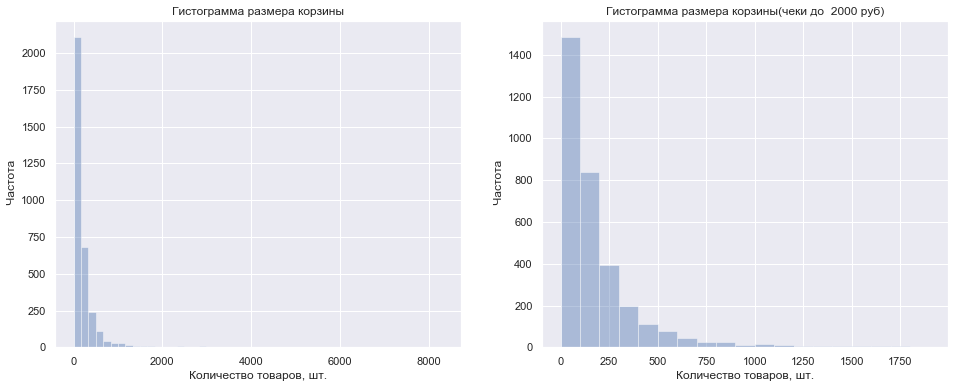

In [11]:
display(purchase_data['item_count'].describe())
print('Количество товаров (95, 97.5 и 99 персентили):', 
      np.percentile(purchase_data['item_count'],[95,97.5,99]))

fig, ax = plt.subplots(1,2, figsize = (16,6))
bin_cutoff = 2000
for i in range(0,2):
    add_label = ''

    if i == 1:
        sns.distplot(purchase_data['item_count'], 
             bins = range(0,bin_cutoff,100),
             kde = False,
             ax = ax[i])
        add_label = f'(чеки до  {bin_cutoff} руб)'
        
    else:   
        sns.distplot(purchase_data['item_count'], 
                     kde = False,
                     ax = ax[i])
        
    ax[i].set(title = 'Гистограмма размера корзины' + add_label,
            xlabel = 'Количество товаров, шт.',
            ylabel = ' Частота')



- 99% корзины состоит из менее 2300 товаров. Максимальное количество товаров = 8315, минимальное 1, в среднем заказе у покупателей   235 товаров. Примем заказы размеров свыше 2000 за аномальные - так останется от 97 до 99 процентов заказов.

Построим гистограмму стоимости покупок:

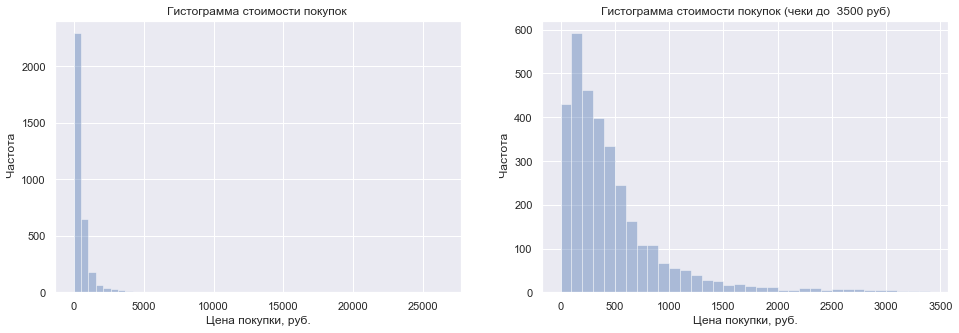

In [12]:
#display(purchase_data['purchase_bill'].describe())
#print('Стоимость покупки (95, 97.5 и 99 персентили):', 
       # np.percentile(purchase_data['purchase_bill'],[95,97.5,99]))

# строим гистограмму покупок

fig, ax = plt.subplots(1,2, figsize = (16,5))
check_cutoff = 3500
for i in range(0,2):
    add_label = ''

    if i == 1:
        sns.distplot(purchase_data['purchase_bill'], 
             bins = range(0,check_cutoff,100),
             kde = False,
             ax = ax[i])
        add_label = f'(чеки до  {check_cutoff} руб)'
        
    else:   
        sns.distplot(purchase_data['purchase_bill'], 
                     kde = False,
                     ax = ax[i])
        
    ax[i].set(title = 'Гистограмма стоимости покупок ' + add_label,
            xlabel = 'Цена покупки, руб.',
            ylabel = ' Частота')


- Стоимость покупки имеет следующие параметры:
    - максимум -  26374.58
    - минимум - 0.95
    - средний = 630.43
    - медиана = 345.88
- по гистограмме слева видно, что большая часть значений лежит в отрезке до 4000, при этом 95, 97.5 и 99 персентили равны соответственно  1884, 2994, 5550. Примем заказы выше 3500 за аномальные, таким образом у нас останется от 97 до 99 процентов заказов.

Сгруппируем данные по дням и неделям и посчитаем количество покупок, покупателей, выручку и средний чек с разбивкой по группам программы лояльности

### 2.3.  Распределение покупателей и покупок по времени     <a id="step5">

Отсеим заказы-выбросы и сгруппируем данные по дням и неделям. Так как у нас неполные данные за всего 3 месяца, мне показалось, что группировка данных по месяцам не даст полезной информации.

In [13]:
# убирем аномальные заказы со слишком высокой стоимостью и огромным количеством товаров

cutoff_purchases = purchase_data.query('purchase_bill >  @check_cutoff or item_count > @bin_cutoff')['purchase_id']\
                                .to_list()
print('Количество уникальных заказов = ', purchase_data.shape[0])
print('Количество уникальных заказов после фильтра = ',purchase_data.query('purchase_id not in @cutoff_purchases').shape[0])
print('Процент отсеяных заказов = {0:0.2%}'.format(
    (purchase_data.shape[0] - purchase_data.query('purchase_id not in @cutoff_purchases').shape[0])/purchase_data.shape[0]))


Количество уникальных заказов =  3328
Количество уникальных заказов после фильтра =  3254
Процент отсеяных заказов = 2.22%


После фильтрации данных у нас осталось больше 97 % заказов

In [14]:
# заказы по дням
daily_data = group_period_data(retail_df.query('purchase_id not in @cutoff_purchases'), period = 'day')
display(daily_data.head())
# по неделям
weekly_data = group_period_data(retail_df.query('purchase_id not in @cutoff_purchases'), period = 'week')

display(weekly_data.head())

monthly_data = group_period_data(retail_df.query('purchase_id not in @cutoff_purchases'), period = 'month')

monthly_data['total_revenue'] = monthly_data['revenue'] + 200*monthly_data['loyalty_program']

display(monthly_data.head())

print(daily_data['day'].min(), daily_data['day'].max())

,day,loyalty_program,purchase_count,revenue,customer_count,avg_check,loyalty_label
0,2016-12-01,0,71,37537.45,58,528.70,обычные покупатели
1,2016-12-01,1,46,14439.01,35,313.89,участники программы лояльности
2,2016-12-02,0,70,31157.85,63,445.11,обычные покупатели
3,2016-12-02,1,60,18027.82,32,300.46,участники программы лояльности
4,2016-12-03,0,35,23048.57,31,658.53,обычные покупатели


,week,loyalty_program,purchase_count,revenue,customer_count,avg_check,loyalty_label
0,2016-12-01,0,331,162331.60,266,490.43,обычные покупатели
1,2016-12-01,1,219,73938.75,153,337.62,участники программы лояльности
2,2016-12-08,0,288,146169.55,228,507.53,обычные покупатели
3,2016-12-08,1,166,66781.38,142,402.30,участники программы лояльности
4,2016-12-15,0,213,114415.14,177,537.16,обычные покупатели


,month,loyalty_program,purchase_count,revenue,customer_count,avg_check,loyalty_label,total_revenue
0,2016-12-01,0,855,434356.59,557,508.02,обычные покупатели,434356.59
1,2016-12-01,1,499,188080.37,320,376.91,участники программы лояльности,188280.37
2,2017-01-01,0,664,361819.68,496,544.91,обычные покупатели,361819.68
3,2017-01-01,1,279,120534.98,226,432.03,участники программы лояльности,120734.98
4,2017-02-01,0,637,316414.82,487,496.73,обычные покупатели,316414.82


2016-12-01 00:00:00 2017-02-28 00:00:00


In [15]:
#daily_data.groupby('day')['customer_count'].sum().reset_index().query('customer_count < 50')
#daily_data.query('(day >"2016-12-19") and (day < "2017-01-07")')
#weekly_data.groupby('week')['customer_count'].sum().reset_index().query('customer_count < 50')

Количество покупателей по дням и неделям:

Средние значения столбца customer_count:
44.205882352941174


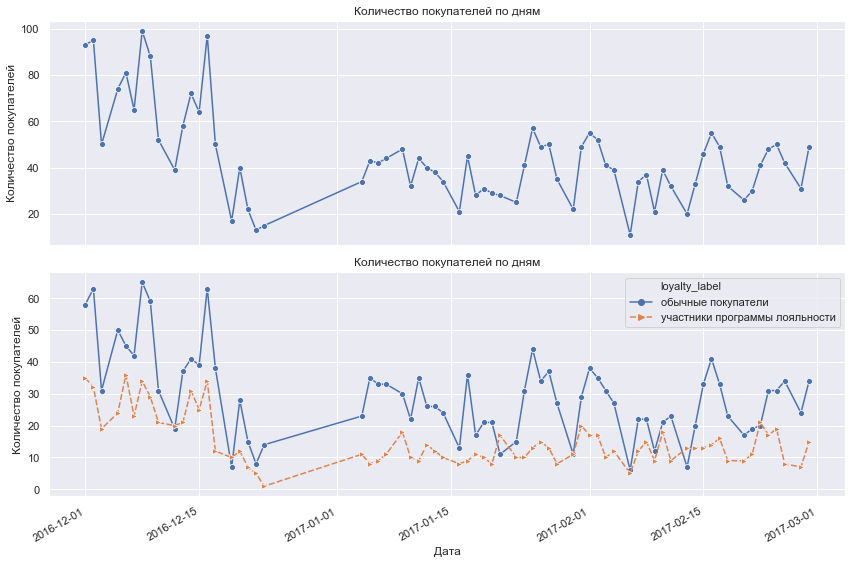

Средние значения по группам:
loyalty_label
обычные покупатели               29.28
участники программы лояльности   14.93
Name: customer_count, dtype: float64
Средние значения столбца customer_count:
217.30769230769232


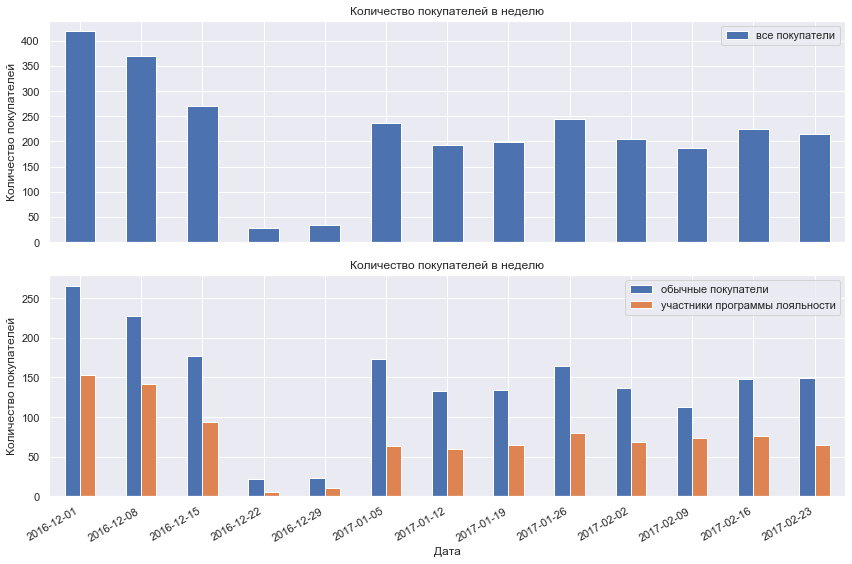

Средние значения по группам:
loyalty_label
обычные покупатели               143.69
участники программы лояльности    73.62
Name: customer_count, dtype: float64


In [16]:
column = 'customer_count'

plot_daily_stats(daily_data, 
                 column = column, 
                 title = 'Количество покупателей по дням', 
                 ylabel ='Количество покупателей')    



plot_period_stats(weekly_data, period = 'week', 
                  column = column, 
                  title = 'Количество покупателей в неделю', 
                  ylabel = 'Количество покупателей')


- Количество покупателей в день колеблется от 100 до 20, в первые недели декабря количество покупателей чуть выше, чем в последующие два месяца, возможно в конце года в магазине действуют какие-то скидки, а вообще зимние месяцы, наверное, не самый активный сезон для строительного магазина
- Среднее количество покупателей в день = 44:
    -  обычные покупатели =             29
    -  участники программы лояльности =   15
    
- Среднее количество покупателей  в неделю = 217
    -  обычные покупатели =                144
    -  участники программы лояльности =   74
    
- данные за период с 2016-12-24	 по 2017-01-03 отсутствуют, поэтому количество покупателей за эти недели такое маленькое

Средний чек по дням и неделям: NB -  сделать дырку с графиках где прерываются данные

Средние значения столбца avg_check:
461.55836183660205


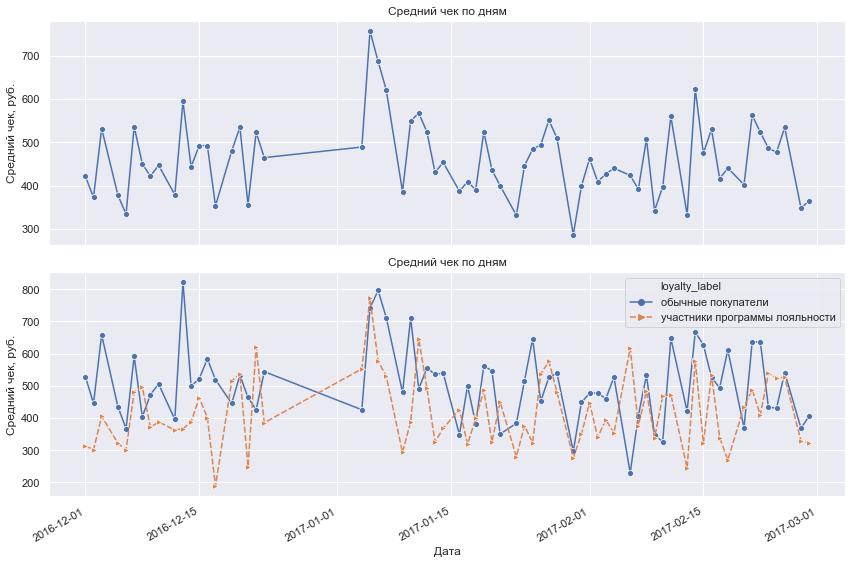

Средние значения по группам:
loyalty_label
обычные покупатели               503.47
участники программы лояльности   419.65
Name: avg_check, dtype: float64
Средние значения столбца avg_check:
473.09019060552305


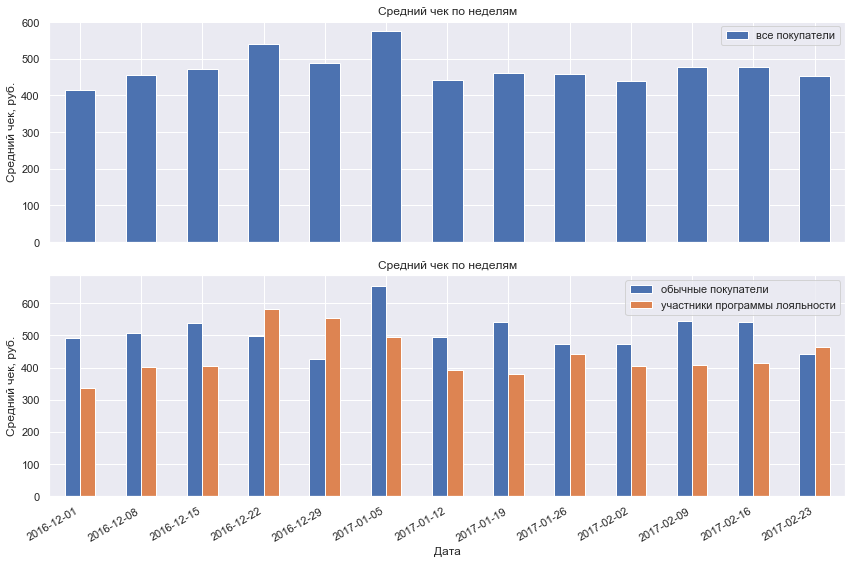

Средние значения по группам:
loyalty_label
обычные покупатели               509.36
участники программы лояльности   436.82
Name: avg_check, dtype: float64


In [17]:
plot_daily_stats(daily_data, 'avg_check', 'Средний чек по дням', 'Средний чек, руб.')    

plot_period_stats(weekly_data, period = 'week',  column = 'avg_check', 
                  title = 'Средний чек по неделям', 
                  ylabel = 'Средний чек, руб.')


- средний чек  колеблется по дням от 400 до 700 руб. 
- средний чек в день =  461:
    - обычные покупатели               503
    - участники программы лояльности   419
- средний чек в неделю  =  473:
    - обычные покупатели               509
    - участники программы лояльности   436
   
Хотя средний чек в неделю у обычных покупателей в среднем больше, чем у участников программы лояльности, но по графикам видно, что в разные дни и недели средний чек бывает выше то у одной, то у другой группы покупателей, нельзя сделать однозначного вывода по графику. 

Общая выручка по дням и неделям:

Средние значения столбца revenue:
22890.10889705883


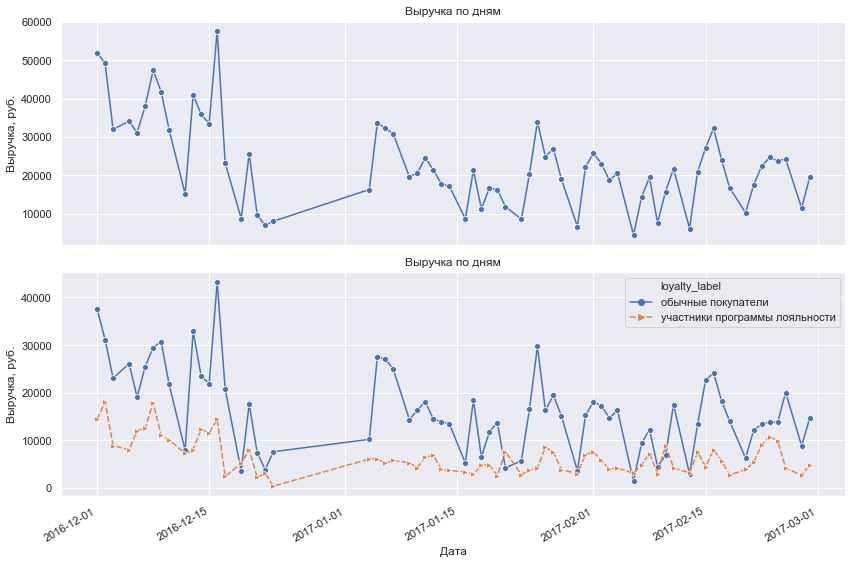

Средние значения по группам:
loyalty_label
обычные покупатели               16361.63
участники программы лояльности    6528.48
Name: revenue, dtype: float64
Средние значения столбца revenue:
119732.87730769215


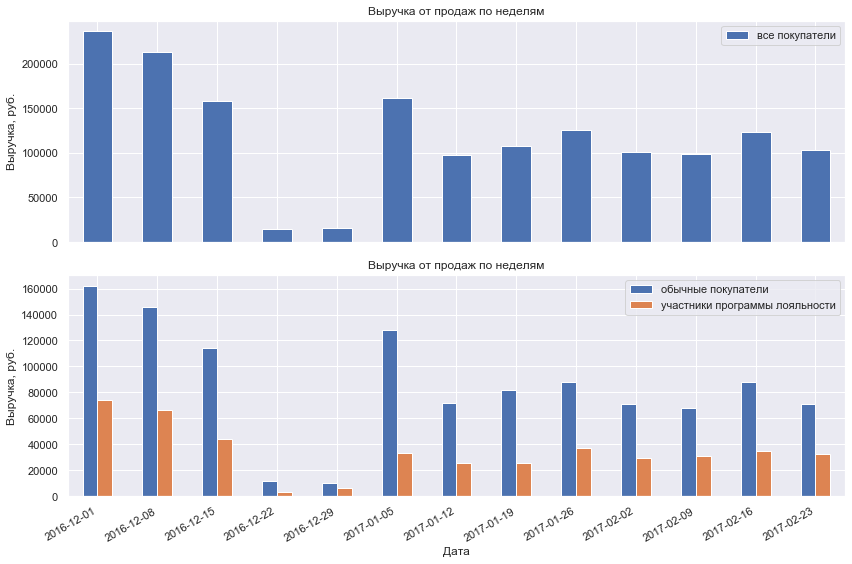

Средние значения по группам:
loyalty_label
обычные покупатели               85583.93
участники программы лояльности   34148.95
Name: revenue, dtype: float64


In [18]:
column = 'revenue'

plot_daily_stats(daily_data, 
                 column = column, 
                 title = 'Выручка по дням', 
                 ylabel ='Выручка, руб.')    

plot_period_stats(weekly_data, period = 'week', 
                  column = column, 
                  title = 'Выручка от продаж по неделям', 
                  ylabel ='Выручка, руб.')


- в начале декабря выручка максимальная, в течение следующих полутора месяцев выручка заметно уменьшаетсят и становится чуть более стабильной со второй половины января.
- выручка с участников программы лояльности ведет себя похоже на выручку с обычных покупателей, но последняя намного больше по величине. Так как обычных покупателе почти в два раза больше, то и выручка с продаж от них соответсвенно выше

Средние значения столбца total_revenue:
519042.46833333484


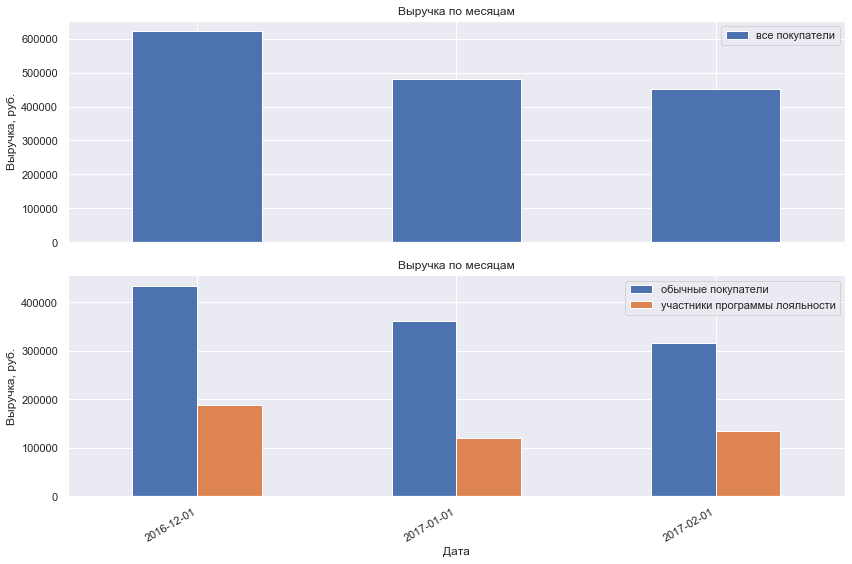

Средние значения по группам:
loyalty_label
обычные покупатели               370863.70
участники программы лояльности   148178.77
Name: total_revenue, dtype: float64


In [19]:
plot_period_stats(monthly_data, period = 'month', 
                  column = 'total_revenue', 
                  title = 'Выручка по месяцам', 
                  ylabel ='Выручка, руб.')

<p style="font-family: verdana; color: dodgerblue">Еще идея: построить только нижний график, а суммарную выручку строить на нем же, но line plot'ом. Так одновременно отразится тенденция во времени, но и распределение на лояльных и не лояльных не пропадет.</p>

### 2.4.  Количество заказов и средний чек для каждого покупателя     <a id="step6">
 
 Посчитаем для каждого покупателя количество заказов в месяц, средний чек в месяц и выручку в месяц (стоимость покупок + стоимость программы лояльности для тех, кто пользуется ею). В большинстве своем люди покупают что-то раз в месяц и далеко не каждый месяц, я добавляла плату за месяц только в тех месяцах, когда были покупки,так как нет информации, что люди продолжали оплачивать программу лояльности в месяцы без покупок.

In [20]:
loyalty_label = {0:'обычные покупатели', 1:'участники программы лояльности'}
loyalty_fee = 200
# cгруппируем данные по пользователям и месяцам и посчитаем

customer_data = ( purchase_data.query('purchase_id not in @cutoff_purchases')
                                .groupby(['customer_id','month','loyalty_program'])
                                .agg(
                                purchase_count = ('purchase_id','count'),     # количество покупок в месяц
                                avg_item_count = ('item_count','mean'),       # среднее количество товаров в корзине 
                                revenue = ('purchase_bill','sum')           #общая выручка с покупок                       
                                ).reset_index()
                     .assign(
                     total_revenue = lambda x: x['revenue'] + loyalty_fee*x['loyalty_program'], #  общая выручка
                     avg_revenue = lambda x: x['total_revenue']/x['purchase_count'],     #средняя выручка с покупки
                     avg_check = lambda x: x['revenue']/x['purchase_count'],     #  средний чек
                     loyalty_label = lambda x: x['loyalty_program'].map(loyalty_label) # для графиков
                     )
                )

display(customer_data.tail())


,customer_id,month,loyalty_program,purchase_count,avg_item_count,revenue,total_revenue,avg_revenue,avg_check,loyalty_label
2334,23939.00,2016-12-01,1,1,47.00,203.09,403.09,403.09,203.09,участники программы лояльности
2335,23939.00,2017-01-01,1,1,403.00,741.61,941.61,941.61,741.61,участники программы лояльности
2336,23948.00,2016-12-01,1,1,69.00,180.84,380.85,380.85,180.84,участники программы лояльности
2337,23962.00,2017-01-01,1,2,13.00,51.68,251.68,125.84,25.84,участники программы лояльности
2338,23962.00,2017-02-01,1,1,29.00,53.25,253.25,253.25,53.25,участники программы лояльности


Гистограмма среднего количества покупок

Средние значения для purchase_count


1.9637899818949909

loyalty_label
обычные покупатели               1.96
участники программы лояльности   1.97
Name: purchase_count, dtype: float64

Процент покупателей по количеству покупок:
Обычные покупатели:


1   63.24
2   16.92
3    8.83
4    4.64
5    2.09
Name: purchase_count, dtype: float64

Участники программы лояльности:


1   56.81
2   19.89
3   13.26
4    4.30
6    2.15
Name: purchase_count, dtype: float64

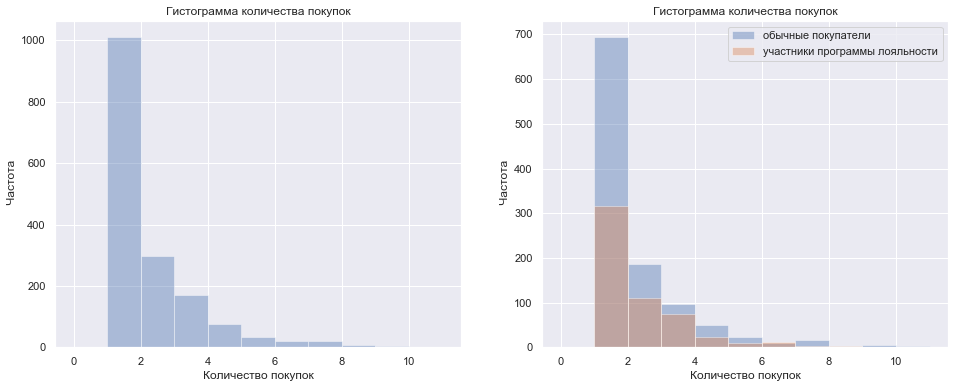

In [21]:
# строим гистограмму покупок
column = 'purchase_count'

data = customer_data.groupby(['customer_id','loyalty_program', 'loyalty_label']).agg({'purchase_count': 'sum'}).reset_index()

plot_customer_hist(customer_data = data, 
                   column = column ,
                   title = 'Гистограмма количества покупок', 
                   xlabel = 'Количество покупок',
                   check_cutoff = 12,
                  binsize = 1)   
#
print('Процент покупателей по количеству покупок:')
print('Обычные покупатели:')
display(data.query('loyalty_program == 0')['purchase_count'].value_counts(normalize = True).head()*100)
print('Участники программы лояльности:')
display(data.query('loyalty_program == 1')['purchase_count'].value_counts(normalize = True).head()*100)


Общее количество покупок:

- подавляющее большинство покупателей совершило всего одну покупку за это время
- можно заметить, что у участников программы лояльности процент покупателей сделавших 2 или 3 покупки выше, чем у обычных покупателей(32% против 25%). Возможно, программа лояльности мотивирует возвращаться за покупками, а возможно это совпадение, у нас слишком мало по времени данных, все-таки в магазине стройматериалов покупки делают не очень часто.

Построим гистограммы выручки с пользователя в месяц:

Средние значения для total_revenue


733.786834117144

loyalty_label
обычные покупатели               722.46
участники программы лояльности   755.61
Name: total_revenue, dtype: float64

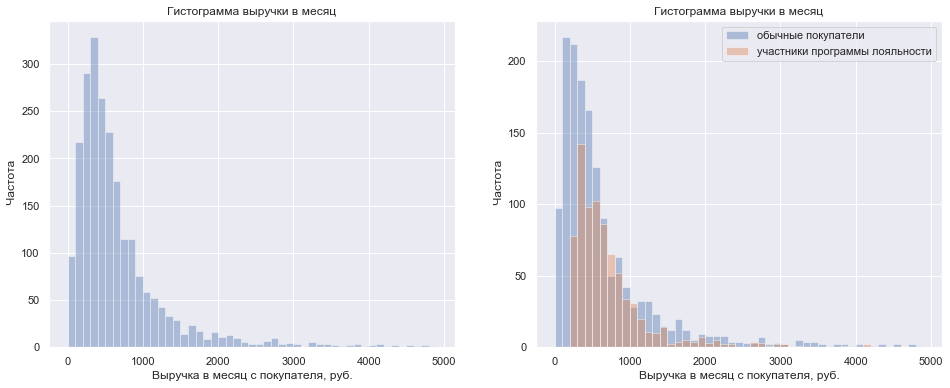

In [22]:
# строим гистограмму  выручки 
column = 'total_revenue'        
plot_customer_hist(customer_data = customer_data, 
                   column = column ,
                   title = 'Гистограмма выручки в месяц', 
                   xlabel = 'Выручка в месяц с покупателя, руб.',
                   check_cutoff = 5000)
 


- средняя выручка в месяц с покупателя = 762 руб:
   - обычные покупатели = 751.31
   - участники программы лояльности = 783.07
   
- гистограмма распределения выручки с покупателя в месяц для участников программы лояльности похожа на гистограмму обычных покупателей, но сдвинута по оси х вправо из-за дополнительной платы за программу лояльности. Участников программы лояльности меньше, но они приносят в среднем большую выручку.

Средние значения для avg_item_count


179.37381834404232

loyalty_label
обычные покупатели               190.02
участники программы лояльности   158.85
Name: avg_item_count, dtype: float64

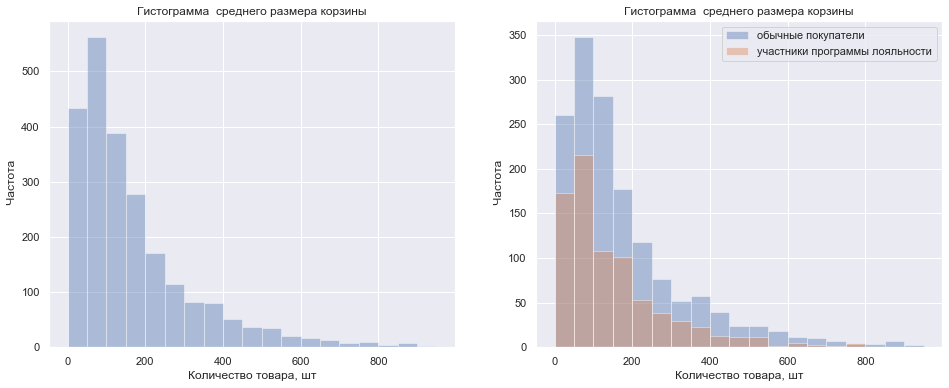

In [23]:
# строим гистограмму покупок
column = 'avg_item_count'

plot_customer_hist(customer_data = customer_data, 
                   column = column ,
                   title = 'Гистограмма  среднего размера корзины', 
                   xlabel = 'Количество товара, шт',
                   check_cutoff = 1000,
                  binsize = 50)    

- средний размер корзины покупателя (количество товаров) = 179:
    - обычные покупатели = 190
    - участники программы лояльности = 158
    
Получается, что в среднем обычные покупатели покупают немного больше товаров в одном чеке.

Средние значения для avg_check


474.4304737563238

loyalty_label
обычные покупатели               508.23
участники программы лояльности   409.29
Name: avg_check, dtype: float64

Средние значения для avg_revenue


533.783240087311

loyalty_label
обычные покупатели               508.23
участники программы лояльности   583.04
Name: avg_revenue, dtype: float64

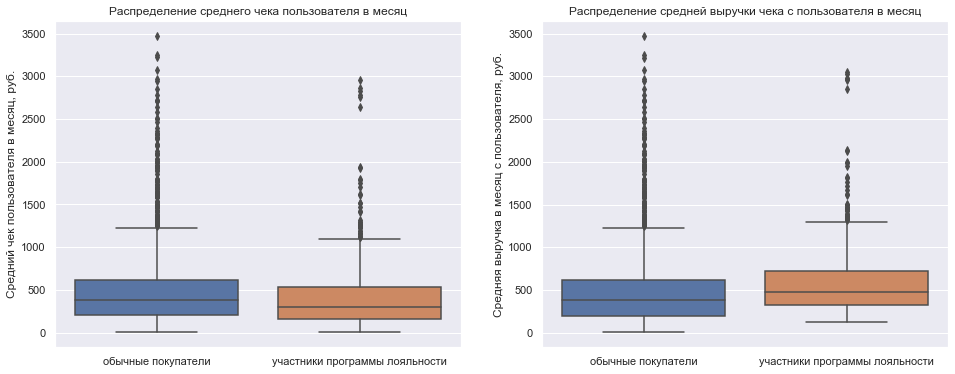

In [24]:
# boxplot для среднего чека и средней выручки с чека

fig, ax = plt.subplots(1,2, figsize = (16,6))   
for i in range(0,2):
        if i == 1:
            
            column = 'avg_revenue'
            sns.boxplot( x = 'loyalty_label',
                        y = 'avg_revenue',
                        data = customer_data,
                       ax = ax[i])
            ax[i].set(title = 'Распределение средней выручки чека с пользователя в месяц',
                xlabel = '',
                ylabel = 'Средняя выручка в месяц с пользователя, руб.')
        else:
            column = 'avg_check'
            sns.boxplot( x = 'loyalty_label',
                        y = 'avg_check',
                        data = customer_data,
                       ax = ax[i])
            ax[i].set(title = 'Распределение среднего чека пользователя в месяц',
                xlabel = '',
                ylabel = 'Средний чек пользователя в месяц, руб.')
                      
        print(f'Средние значения для {column}')
        display(customer_data[column].mean())
        display(customer_data.groupby('loyalty_label')[column].mean()) 


   
- средний чек  покупателя в месяц  = 474, он выше у обычных покупателей:
   - обычные покупатели = 508
   - участники программы лояльности = 409
   
- средняя выручка с заказа в месяц  = 533, она выше у участников программы лояльности из-за ежемесячной оплаты за программу лояльности.
   - обычные покупатели = 508
   - участники программы лояльности = 583 

При среднем чеке в 474 руб. плата за программу лояльности в 200 руб. составляет почти половину среднего чека, при этом люди покупают в большинстве случаев один раз в месяц или реже, поэтому выручка в программе лояльности выше, несмотря на меньший средний счет. Это как будто в программе лояльности мы на каждую пару покупателей добавили еше один заказ средней стоимости.



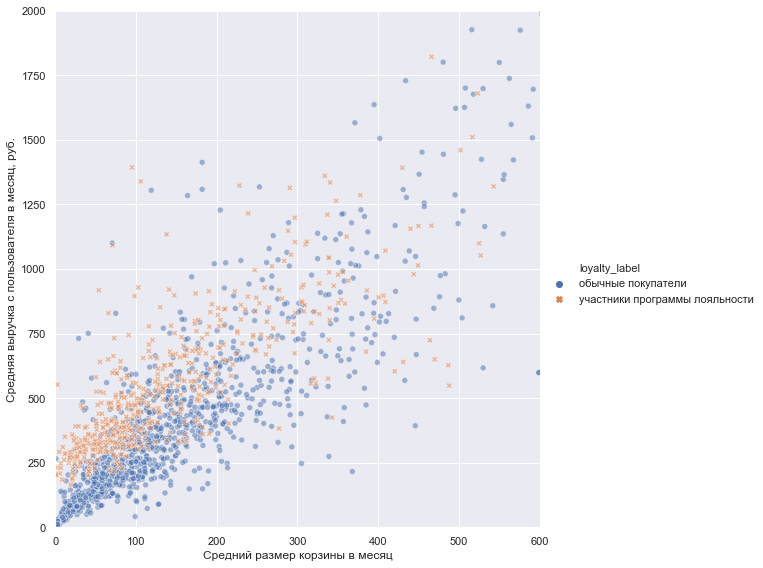

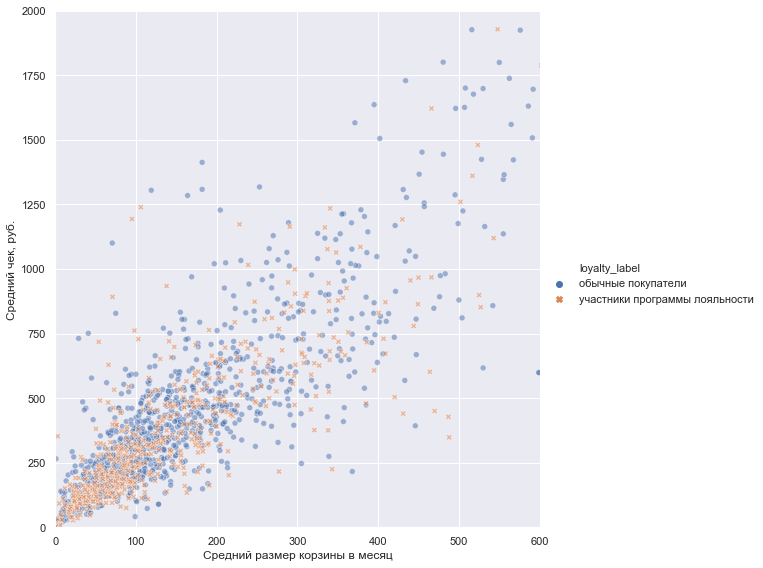

In [25]:
#  построим точечная диаграмму (количество товаров в заказе и средняя выручка с заказа)

data = customer_data.groupby(['customer_id','loyalty_label']).agg({'avg_item_count': 'mean',
                                                 'avg_revenue':'mean',
                                                 'avg_check':'mean'}).reset_index()
                                           
ax = sns.relplot(x='avg_item_count', 
          y = 'avg_revenue',
          hue="loyalty_label", style="loyalty_label",
          data = data,
          height=8, # make the plot 5 units high
          aspect=1,  alpha = 0.5) # height should be three times width)
ax.set(xlim=(0,600),ylim=(0,2000))
ax.set(#title = 'Распределение среднего чека пользователя в месяц',
                xlabel = 'Средний размер корзины в месяц',
                ylabel = 'Средняя выручка с пользователя в месяц, руб.')
plt.show()

ax = sns.relplot(x='avg_item_count', 
          y = 'avg_check',
          hue="loyalty_label", style="loyalty_label",
          data = data,
          height=8, # make the plot 5 units high
          aspect=1, alpha = 0.5) # height should be three times width)
ax.set(xlim=(0,600),ylim=(0,2000))
ax.set(#title = 'Распределение среднего чека пользователя в месяц',
                xlabel = 'Средний размер корзины в месяц',
                ylabel = 'Средний чек, руб.')

- По графику видно, что с ростом количества товаров растет средняя выручка с заказа, что логично.
- По распределению пользователей видно, что участники программы лояльности  и обычные покупатели распределены похоже, плата за программу лояльности поднятимает вверх по оси y.
- На втором графике (со средним чеком), нет заметной разницы в распределении участников и не участников программы лояльности

## 3.  Проверка влияния программы лояльности клиентов на средний чек и объем покупок     <a id="step7">


In [26]:
program_stat = customer_data.pivot_table(index = 'loyalty_program',
                                         values = ['avg_item_count','avg_revenue', 'avg_check'],
                                         aggfunc = {'mean',np.std})
display(program_stat.T)

loyalty_program          0      1
avg_check      mean 508.23 409.29
               std  477.97 382.56
avg_item_count mean 190.02 158.85
               std  202.39 163.16
avg_revenue    mean 508.23 583.04
               std  477.97 385.64

- видно разделение 

### 3.1.  Средняя выручка с заказа     <a id="step8">

Проверим есть ли разница в средней выручке с чека у обычных покупателей и покупателей с программой лояльности. Так как распределения не нормальные, используем тест Уилкоксона-Манна-Уитни с критическим уровнем статистической значимости = 0.05

In [27]:
# найдем среднюю выручку за месяц для каждой группы

loyalty_revenue_stat = customer_data.pivot_table(index = 'loyalty_program', values = ['avg_revenue'])
display(loyalty_revenue_stat)

alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотез

print('Нулевая гипотеза - средняя выручка с заказа у обычных покупателей и покупателей, участвующих в программе лояльности, равна')
print('Альтернативная гипотеза - средняя выручка с заказа у обычных покупателей меньше, чем средняя выручка с заказа у покупателей, \
участвующих в программе лояльности ')    
    
results = st.mannwhitneyu(customer_data.query('loyalty_program == 0')['avg_revenue'], 
                          customer_data.query('loyalty_program == 1')['avg_revenue'],
                         alternative = 'less')

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha) and (loyalty_revenue_stat.loc[0][0] < loyalty_revenue_stat.loc[1][0]):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
    print ('Принимаем альтернативную гипотезу')
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя")

,avg_revenue
loyalty_program,
0,508.23
1,583.04


Нулевая гипотеза - средняя выручка с заказа у обычных покупателей и покупателей, участвующих в программе лояльности, равна
Альтернативная гипотеза - средняя выручка с заказа у обычных покупателей меньше, чем средняя выручка с заказа у покупателей, участвующих в программе лояльности 
p-значение:  2.2494540379209884e-21
Отвергаем нулевую гипотезу: разница статистически значима
Принимаем альтернативную гипотезу


- Средняя выручка с заказа:
    -  у обычных покупателей = 508
    -  у покупателей, пользующихся программой лояльности = 583
    
- разница в средней выручке с заказа статистически значимая, значит можем принять альтернативную гипотезу, что средняя выручка с заказа у покупателей, участвующих в программе лояльности, выше.

### 3.2.  Средний размер корзины и средний чек     <a id="step9">

Проверим есть ли разница в среднем количестве товаров в заказе у обычных покупателей и покупателей с программой лояльности. Так как распределения не нормальные, используем тест Уилкоксона-Манна-Уитни с критическим уровнем статистической значимости = 0.05

In [28]:
# найдем средний размер корзины  за месяц для каждой группы

loyalty_revenue_stat = customer_data.pivot_table(index = 'loyalty_program', values = ['avg_item_count']).reset_index()
display(loyalty_revenue_stat)

alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотез
    
print('Нулевая гипотеза - среднее количество товаров в покупке у обычных покупателей и покупателей, участвующих в программе лояльности, равно')
print('Альтернативная гипотеза - среднее количество товаров в покупке у обычных покупателей больше, чем у покупателей, \
участвующих в программе лояльности ')    

results = st.mannwhitneyu(customer_data.query('loyalty_program == 0')['avg_item_count'], 
                        customer_data.query('loyalty_program == 1')['avg_item_count'],
                         alternative = 'greater')

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha) and (loyalty_revenue_stat.loc[0][0] > loyalty_revenue_stat.loc[1][0]):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя")
    
# найдем средний чек  в месяц для каждой группы

loyalty_revenue_stat = customer_data.pivot_table(index = 'loyalty_program', values = ['avg_check']).reset_index()
display(loyalty_revenue_stat)

alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотез
    
print('Нулевая гипотеза - средний чек у обычных покупателей и покупателей, участвующих в программе лояльности, равно')
print('Альтернативная гипотеза - средний чек у обычных покупателей больше, чем у покупателей, \
участвующих в программе лояльности ')    

results = st.mannwhitneyu(customer_data.query('loyalty_program == 0')['avg_check'], 
                        customer_data.query('loyalty_program == 1')['avg_check'],
                         alternative = 'greater')

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha)  and (loyalty_revenue_stat.loc[0][0] > loyalty_revenue_stat.loc[1][0]):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя")

,loyalty_program,avg_item_count
0,0,190.02
1,1,158.85


Нулевая гипотеза - среднее количество товаров в покупке у обычных покупателей и покупателей, участвующих в программе лояльности, равно
Альтернативная гипотеза - среднее количество товаров в покупке у обычных покупателей больше, чем у покупателей, участвующих в программе лояльности 
p-значение:  4.79827549843922e-05
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


,loyalty_program,avg_check
0,0,508.23
1,1,409.29


Нулевая гипотеза - средний чек у обычных покупателей и покупателей, участвующих в программе лояльности, равно
Альтернативная гипотеза - средний чек у обычных покупателей больше, чем у покупателей, участвующих в программе лояльности 
p-значение:  7.158223821298059e-08
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


- среднее количество товаров в заказе:
    -  у обычных покупателей = 190
    -  у покупателей, пользующихся программой лояльности = 159
- средний чек:
    -  у обычных покупателей = 508
    -  у покупателей, пользующихся программой лояльности = 409
    
- разница в обоих параметрах статистически значимая, среднее количество товаров в покупке и средний чек у обычных покупателей больше.

### 3.3. Процент возвратов товара     <a id="step10">

Посмотрим есть статистически значимая разница в проценте возвратов товаров в группе обычных покупателей и покупателей, пользующейся программой лояльности.

In [29]:
column = 'quantity'

successes_0 = abs(retail_returns.query('loyalty_program == 0')[column].sum())
total_0 = retail_df.query('loyalty_program == 0')[column].sum()

successes_1 = abs(retail_returns.query('loyalty_program == 1')[column].sum())
total_1 = retail_df.query('loyalty_program == 1')[column].sum()

print(f'Количество купленных товаров в группе обычных покупателей = {total_0} ')
print(f'Количество купленных товаров в группе покупателей, участвующих в программе лояльности = {total_1} ')

print(f'Количество возвратов товаров в группе обычных покупателей = {successes_0} ')
print(f'Количество возвратов товаров в группе покупателей, участвующих в программе лояльности = {successes_1} ')
# пропорция успехов в первой группе:
p1 = successes_0/total_0
print('Процент возвратов возвратов товаров в группе обычных покупателей = {0:.2%} '.format(p1))
# пропорция успехов во второй группе:
p2 = successes_1/total_1
print('Процент возвратов возвратов товаров в группе покупателей, участвующих в программе лояльности= {0:.2%} '.format(p2))

p_value = check_stat_significance(successes_0, total_0,
                          successes_1, total_1, 
                          alpha = alpha
                         )

Количество купленных товаров в группе обычных покупателей = 550543 
Количество купленных товаров в группе покупателей, участвующих в программе лояльности = 233346 
Количество возвратов товаров в группе обычных покупателей = 21369 
Количество возвратов товаров в группе покупателей, участвующих в программе лояльности = 4653 
Процент возвратов возвратов товаров в группе обычных покупателей = 3.88% 
Процент возвратов возвратов товаров в группе покупателей, участвующих в программе лояльности= 1.99% 
1.958337289112292e-07
----------------------------------------------------------------------
Разница в долях = 1.89%
p-значение =  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница
----------------------------------------------------------------------


- Процент возвратов возвратов товаров:
    - в группе обычных покупателей = 3.88% 
    - в группе покупателей, участвующих в программе лояльности= 1.99%
    
- Среди обычных покупателей доля возвратов больше на 1.89% и это является статистически значимой разницей, участники программы лояльности меньше товаров возвращают.

## 4.  Выводы     <a id="step11">


- По результатам оценки гипотез можно сделать вывод, что средний чек и количество товаров в покупке не зависит от программы лояльности и даже выше у покупателей не пользующихся программой лояльности. 
- При этом средняя выручка с покупки выше у участников программы лояльности за счет платы за программу, эта гипотеза подтверждается.
- Мы не знаем, сколько затрачено на программу лояльности, поэтому не можем сделать вывод о том, стоит ли она затрат, но программа точно приносит дополнительную выручку.
- Среди обычных покупателей доля возвратов больше на 1.89% и это является статистически значимой разницей, участники программы лояльности меньше товаров возвращают, возможно это говорит о большей лояльности участников программы лояльности.
- Мне кажется, что здесь у нас мало данных, чтобы верить этим результатам. Данные собраны зимой, мне кажется, что это не репрезативный период - с одной стороны в это время в магазине могут быть акции к Новому году, а с другой зимой в стоительных магазинах низкий сезон, как мне кажется.

Рекомендации:
- оценить затраты на программу лояльности - тогда можно сделать вывод о ее окупаемости
- собрать больше данных и за более длительный период для объективного анализа - тогда можно будет подсчитать, например, разницу в retetnion rate двух групп.